In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [3]:
ep_data = pd.read_csv('EP.csv')

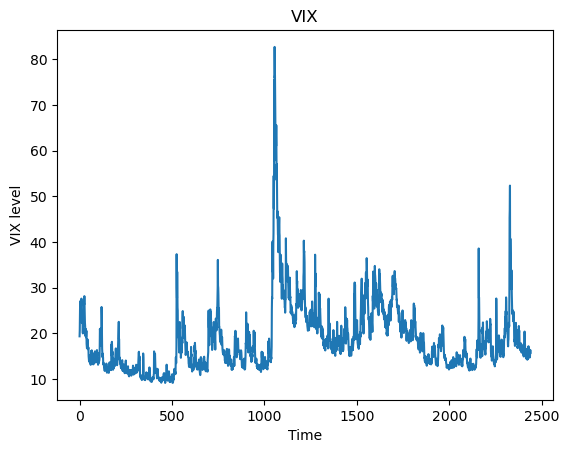

In [4]:
imp_vol_1m = ep_data['VIX'].values

plt.plot(imp_vol_1m)
plt.title('VIX')
plt.ylabel('VIX level')
plt.xlabel('Time')
plt.show()

In [5]:
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct

imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m > imp_vol_25pct) & (imp_vol_1m <= imp_vol_75pct)

high_vol_indices = imp_vol_1m > imp_vol_75pct

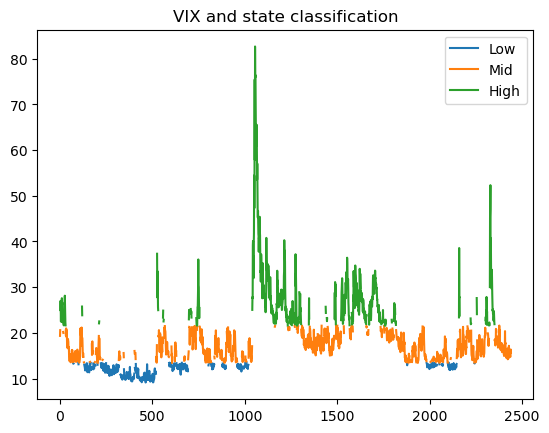

In [6]:
vol_low = np.ma.masked_where(low_vol_indices == False, imp_vol_1m)
vol_mid = np.ma.masked_where(mid_vol_indices == False, imp_vol_1m)
vol_high = np.ma.masked_where(high_vol_indices == False, imp_vol_1m)

x = np.arange(0, len(imp_vol_1m))

plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.legend(['Low', 'Mid', 'High'])
plt.title('VIX and state classification')
plt.show()

In [7]:
# Use your log returns as the stationary data
st_df = ep_data[['log_ret']].copy()

# Exponential decay prior
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

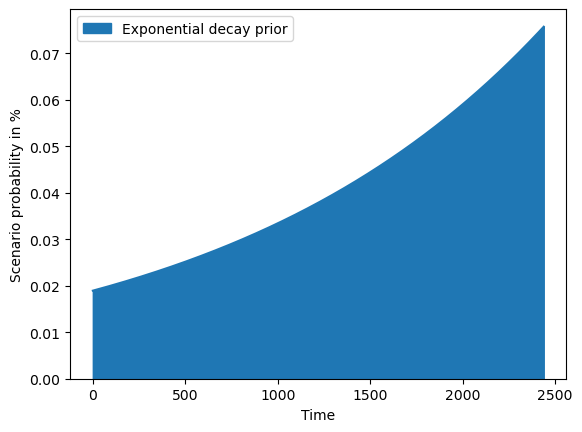

In [8]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [9]:
# Compute view values for Entropy Pooling views
mu_low = np.mean(imp_vol_1m[low_vol_indices])
sigma_low = np.std(imp_vol_1m[low_vol_indices])

mu_mid = np.mean(imp_vol_1m[mid_vol_indices])
sigma_mid = np.std(imp_vol_1m[mid_vol_indices])

mu_high = np.mean(imp_vol_1m[high_vol_indices])
sigma_high = np.std(imp_vol_1m[high_vol_indices])

In [10]:
# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
b_low = np.array([[1.], [mu_low]])
b_mid = np.array([[1.], [mu_mid]])
b_high = np.array([[1.], [mu_high]])

G = imp_vol_1m[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

In [11]:
# Compute Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

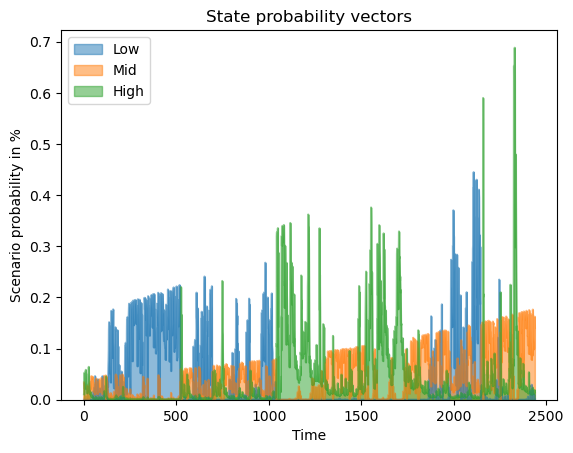

In [12]:
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
pd.DataFrame(100 * states_prob, columns=['Low', 'Mid', 'High']).plot(kind='area', stacked=False)
plt.title('State probability vectors')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.show()

In [13]:
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

In [14]:
# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

In [15]:
# Simulate historical observations
S = 10000
H = 21
np.random.seed(0)
sim = resampling(S, H, states_vector[-1], states_prob, states_vector)

In [16]:
# Extract stationary transformations and compute cumulative sums
N_tilde = st_df.shape[1]
st_sim = np.full((S, N_tilde, H), np.nan)
for s in range(S):
    st_sim[s, :, :] = st_df.values[sim[s, :], :].T
st_sim_cumsum = np.cumsum(st_sim, axis=2)

In [17]:
print(f'The stationary transformations simulation dimension is {st_sim.shape}')

The stationary transformations simulation dimension is (10000, 1, 21)


/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


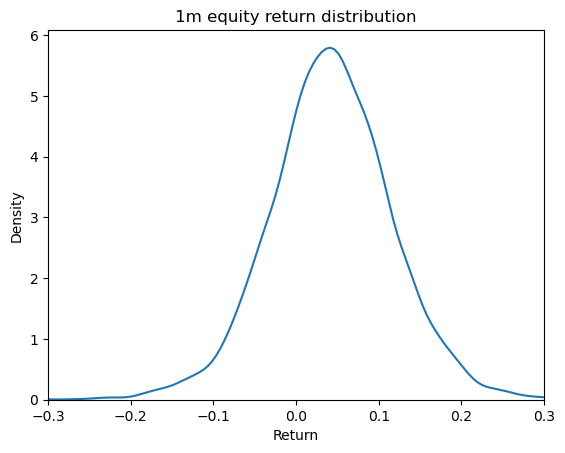

In [18]:
import seaborn as sns

# Equity returns
equity_returns = np.exp(st_sim_cumsum[:, 0, -1]) - 1
sns.kdeplot(equity_returns)
plt.title('1m equity return distribution')
plt.xlabel('Return')
plt.xlim([-0.3, 0.3])
plt.show()

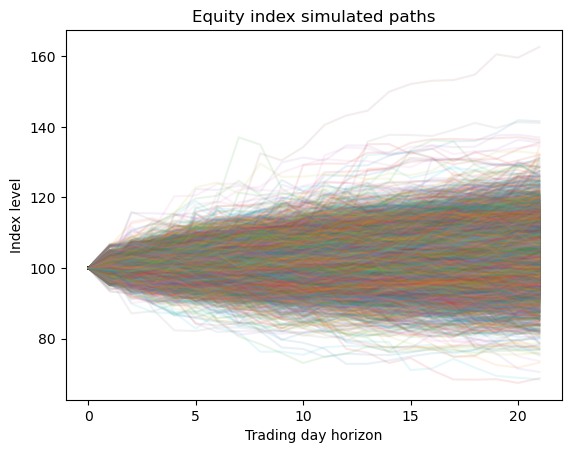

In [19]:
# Equity paths
init_val = 100  # Starting index level
equity_paths = np.concatenate((np.full((S, 1), init_val),
                               init_val * np.exp(st_sim_cumsum[:, 0, :])), axis=1)
plt.plot(equity_paths.T, alpha=0.1)
plt.title('Equity index simulated paths')
plt.ylabel('Index level')
plt.xlabel('Trading day horizon')
plt.show()

/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


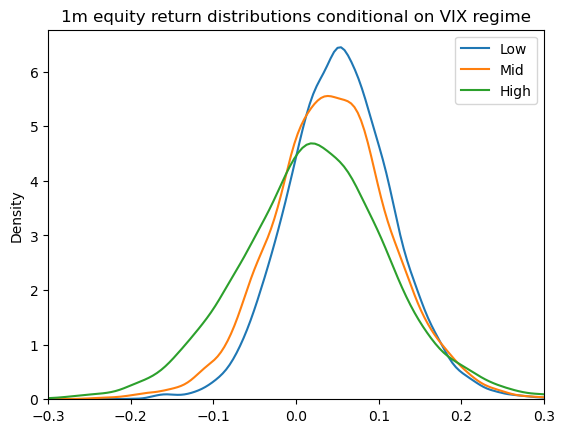

In [20]:
# Simulate historical observations by scenario
S = 10000
H = 21
np.random.seed(0)
sim0 = resampling(S, H, 0, states_prob, states_vector)  # Starting in Low VIX
sim1 = resampling(S, H, 1, states_prob, states_vector)  # Starting in Mid VIX
sim2 = resampling(S, H, 2, states_prob, states_vector)  # Starting in High VIX

# Extract equity stationary transformations and compute returns
equity_low = np.full((S, H), np.nan)
equity_mid = np.full((S, H), np.nan)
equity_high = np.full((S, H), np.nan)
for s in range(S):
    equity_low[s, :] = st_df.values[sim0[s, :], 0]
    equity_mid[s, :] = st_df.values[sim1[s, :], 0]
    equity_high[s, :] = st_df.values[sim2[s, :], 0]

return_low = np.exp(np.cumsum(equity_low, axis=1)) - 1
return_mid = np.exp(np.cumsum(equity_mid, axis=1)) - 1
return_high = np.exp(np.cumsum(equity_high, axis=1)) - 1

sns.kdeplot(return_low[:, -1])
sns.kdeplot(return_mid[:, -1])
sns.kdeplot(return_high[:, -1])
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m AAPL return distributions conditional on VIX regime')
plt.xlim([-0.3, 0.3])
plt.show()

In [21]:
num_states = states_prob.shape[1]
transition_matrix = np.full((num_states, num_states), np.nan)
states = np.unique(states_vector)
for row_state in states:
    for col_state in states:
        transition_matrix[row_state, col_state] = np.sum(states_prob[states_vector == col_state, row_state])

In [22]:
# Print results
np.round(transition_matrix, 3)

array([[0.931, 0.069, 0.   ],
       [0.063, 0.909, 0.028],
       [0.014, 0.195, 0.791]])

In [23]:
# Calculate aggregate effective number of scenarios and relative entropy
q_total = (q_low + q_mid + q_high) / 3  # Average posterior

ens_total = np.exp(-np.sum(q_total * np.log(q_total)))
ens_pct_total = 100 * ens_total / T_tilde

re_total = np.sum(q_total * (np.log(q_total) - np.log(p_exp)))
re_pct_total = 100 * re_total / np.log(T_tilde)

print(f"Total Effective Number of Scenarios: {ens_pct_total:.2f}%")
print(f"Total Relative Entropy: {re_pct_total:.2f}%")

Total Effective Number of Scenarios: 85.84%
Total Relative Entropy: 1.96%
